In [1]:
from functools import partial
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision

sys.path.append('..')
from models.resnet import resnet18
from methods import EL2N, GraNd

device = torch.device('cuda:1')

### Experimant Setting
#### Hyperparameter Setting

In [2]:
bs        = 512
lr        = 0.001
seed      = 0
epoch     = 20
dis_epoch = 10

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

#### Dataset Setting

In [3]:
cifar10_path = '/home/wupj/data/cv/CIFAR-10'
num_classes  = 10
n_channel    = 3

transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.Resize(32),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
transform_test = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
trainset = torchvision.datasets.CIFAR10(cifar10_path, train=True, transform=transform_train)
testset  = torchvision.datasets.CIFAR10(cifar10_path, train=False, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

#### Model Setting & Training

In [4]:
scaler    = torch.cuda.amp.GradScaler()
criterion = nn.CrossEntropyLoss()
model_fn  = partial(resnet18, num_classes=num_classes, n_channel=n_channel)

def train_a_new_model(dataloader, epoch):
    model     = model_fn().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    schedule  = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2*epoch)

    for _ in range(epoch):
        for x, y in dataloader:
            x, y = x.to(device), y.to(device) 
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                logistic = model(x)
                loss = criterion(logistic, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            schedule.step()
    return model, optimizer

def test(model, dataloader):
    loss = 0
    acc  = 0
    model.eval()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device) 
        with torch.no_grad():
            logistic = model(x)
            _loss = criterion(logistic, y)
        loss += _loss.item()
        acc  += torch.argmax(logistic, dim=1).eq(y).sum().item() / y.size(0)
    loss /= len(testloader)
    acc  /= len(testloader) / 100
    return loss, acc

In [5]:
model, optimizer = train_a_new_model(trainloader, epoch=dis_epoch)

# test on the last epoch.
loss, acc = test(model, testloader)
print(f'Epoch: {dis_epoch} | test loss: {loss:.5f} | test acc: {acc:.2f}%.')

Epoch: 10 | test loss: 0.46039 | test acc: 84.35%.


### Data Pruning
#### Calculate and Visualize EL2N & GraNd Score
Gradient norm (GraNd) score is the expectation changes of the fully connected (FC) layer's gradient for a given sample, defined as,
$$\mathbb{E}_{\mathbf{w}_t} \|g_t(x,y)\|_2,$$
where $\bf{w}_t$ is the weight of last FC layer at step $t$, and $g_t(x,y)$ is the FC layer's gradient w.r.t. a given sample $(x,y)$, that is $g_t(x,y)= \nabla_{\mathbf{w}_t} \mathcal{l} \left( p(\mathbf{w_t}, x), y\right)$. When using cross entropy loss as the loss function $\mathcal{l}$, the GraNd score can be written as,
$$\mathbb{E}\|{p(\mathbf{w}_t},x) -y\|_2,$$
that is the Error L2-Norm (EL2N) scores, which is more efficient than GraNd because it omits the calculation of the FC layer's gradient w.r.t. each sample.

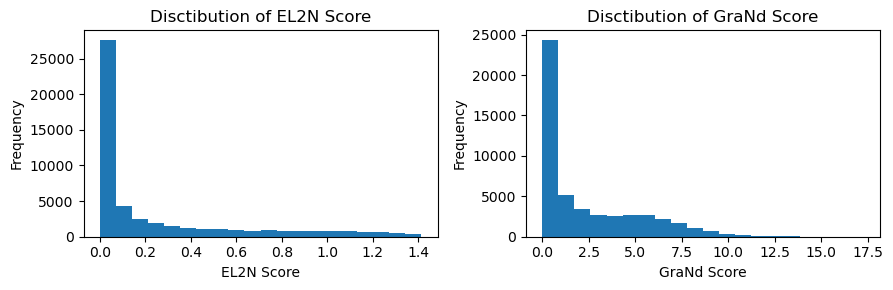

In [6]:
sampleloader = torch.utils.data.DataLoader(trainset, batch_size=2000, shuffle=False)
el2n_scorer  = EL2N(model=model, n_classes=num_classes, order=2)
el2n_score   = el2n_scorer.scores(sampleloader)
grand_scorer = GraNd(model=model, order=2)
grand_score  = grand_scorer.scores(sampleloader)

fig, ax = plt.subplots(1,2, dpi=100, figsize=(9,3))
ax[0].hist(el2n_score, 20)
ax[0].set_title('Disctibution of EL2N Score')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('EL2N Score')
ax[1].hist(grand_score, 20)
ax[1].set_title('Disctibution of GraNd Score')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('GraNd Score')
plt.tight_layout()
plt.show()

### Train on Pruned Data
Here I only trained each model by 20 epochs in order to obtain the results quickly.

In [7]:
el2n_score  = pd.DataFrame(dict(score=el2n_score)).sort_values(by='score')
grand_score = pd.DataFrame(dict(score=grand_score)).sort_values(by='score')

pruning_rate = 0.2
keeping_num  = round(len(trainset) * (1 - pruning_rate))

random_index      = np.random.choice(len(trainset), keeping_num, replace=False)
lowest_el2n_idx   = el2n_score.iloc[:keeping_num].index.tolist()
highest_el2n_idx  = el2n_score.iloc[len(trainset) - keeping_num:].index.tolist()
lowest_grand_idx  = grand_score.iloc[:keeping_num].index.tolist()
highest_grand_idx = grand_score.iloc[len(trainset) - keeping_num:].index.tolist()

In [8]:
# train & test on the full dataset.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
model, _ = train_a_new_model(trainloader, epoch)
loss, acc = test(model, testloader)
print(f'Full Dtaset   | test loss: {loss:.5f} | test acc: {acc:.2f}%.')

# train & test on the subset with the lowest EL2N score.
subset      = torch.utils.data.Subset(trainset, lowest_el2n_idx)
trainloader = torch.utils.data.DataLoader(subset, batch_size=bs, shuffle=True)
model, _    = train_a_new_model(trainloader, epoch)
loss, acc   = test(model, testloader)
print(f'Lowest EL2N   | test loss: {loss:.5f} | test acc: {acc:.2f}%.')

# train & test on the subset with the highest EL2N score.
subset      = torch.utils.data.Subset(trainset, highest_el2n_idx)
trainloader = torch.utils.data.DataLoader(subset, batch_size=bs, shuffle=True)
model, _    = train_a_new_model(trainloader, epoch)
loss, acc   = test(model, testloader)
print(f'Highest EL2N  | test loss: {loss:.5f} | test acc: {acc:.2f}%.')

# train & test on the subset with the lowest GraNd score.
subset      = torch.utils.data.Subset(trainset, lowest_grand_idx)
trainloader = torch.utils.data.DataLoader(subset, batch_size=bs, shuffle=True)
model, _    = train_a_new_model(trainloader, epoch)
loss, acc   = test(model, testloader)
print(f'Lowest GraNd  | test loss: {loss:.5f} | test acc: {acc:.2f}%.')

# train & test on the subset with the highest GraNd score.
subset      = torch.utils.data.Subset(trainset, highest_grand_idx)
trainloader = torch.utils.data.DataLoader(subset, batch_size=bs, shuffle=True)
model, _    = train_a_new_model(trainloader, epoch)
loss, acc   = test(model, testloader)
print(f'Highest GraNd | test loss: {loss:.5f} | test acc: {acc:.2f}%.')

# train & test on a random subset of the same scale.
subset      = torch.utils.data.Subset(trainset, random_index)
trainloader = torch.utils.data.DataLoader(subset, batch_size=bs, shuffle=True)
model, _ = train_a_new_model(trainloader, epoch)
loss, acc = test(model, testloader)
print(f'Random Subset | test loss: {loss:.5f} | test acc: {acc:.2f}%.')

Full Dtaset   | test loss: 0.34742 | test acc: 88.39%.
Lowest EL2N   | test loss: 0.65622 | test acc: 84.81%.
Highest EL2N  | test loss: 0.37416 | test acc: 87.38%.
Lowest GraNd  | test loss: 0.46010 | test acc: 85.13%.
Highest GraNd | test loss: 0.44549 | test acc: 85.60%.
Random Subset | test loss: 0.41628 | test acc: 86.38%.
